<a href="https://colab.research.google.com/github/zzhenxi/TIL/blob/main/%5BNLP%EB%B3%B5%EC%8A%B5%5D_%EC%96%B8%EC%96%B4%EB%AA%A8%EB%8D%B8%EA%B3%BC_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

전통적인 언어모델    
통계적 언어모델 :   
통계적 언어모델은 횟수 기반으로 확률을 계산하기 때문에 희소성 문제를 가짐    
1 times, 2 times는 있지만, 만약 말뭉치에 7 times가 없다면 7 times가 들어가는 문장을 만들 수 있을까? 만들 수 X! -> **희소성 문제**    


희소성 문제를 해결하기 위해    
1. n-gram 
2. back-off : n-gram의 n에 대해 n보다 작은 숫자를 적용해주는 방식    
예를 들어 I love twosomeplace cakes 라는 문장이 말뭉치에 나오지 않았다면, n을 단어수인 4이하로 설정해준다.
3. smoothing : 말뭉치에 등장하지 않는 단어에 대해 0대신 다른 값을 넣어줘서 등장 확률을 높여줌, 반대로 너무 많이 등장하는 단어에 대해서는 확률값을 좀 낮춰준다. 

RNN 구현

In [ ]:
# 배웠던 RNN을 간단한 코드로 살펴보면 다음과 같습니다. 
import numpy as np

class RNN:
  def __init__(self, Wx, Wh, b):
    self.params = [Wx, Wh, b]
    # 필요한 가중치를 초기화하여 줍니다.
    self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
    self.cache = None

  def forward(self, x, h_prev):
    Wx, Wh, b = self.params
    t = np.matmul(h_prev, Wh) + np.matmul(x, Wx) + b # 이 부분을 위의 그림과 연관지어 생각해보세요!
    h_next = np.tanh(t)

    self.cache = (x, h_prev, h_next)
    return h_next

LSTM을 이용한 텍스트 감성 분류 

In [6]:
from __future__ import print_function

from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.datasets import imdb

# 파라미터를 설정합니다.
max_features = 20000 
maxlen = 80 # 한 문장 길이
batch_size = 32

# 데이터를 불러옵니다.
print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

Loading data...
25000 train sequences
25000 test sequences


In [7]:
# Sequence를 Padding 하여줍니다.
print('Pad Sequences (samples x maxlen)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape: ', x_train.shape)
print('x_test shape: ', x_test.shape)

Pad Sequences (samples x maxlen)
x_train shape:  (25000, 80)
x_test shape:  (25000, 80)


In [8]:
x_train[0]

array([   15,   256,     4,     2,     7,  3766,     5,   723,    36,
          71,    43,   530,   476,    26,   400,   317,    46,     7,
           4, 12118,  1029,    13,   104,    88,     4,   381,    15,
         297,    98,    32,  2071,    56,    26,   141,     6,   194,
        7486,    18,     4,   226,    22,    21,   134,   476,    26,
         480,     5,   144,    30,  5535,    18,    51,    36,    28,
         224,    92,    25,   104,     4,   226,    65,    16,    38,
        1334,    88,    12,    16,   283,     5,    16,  4472,   113,
         103,    32,    15,    16,  5345,    19,   178,    32],
      dtype=int32)

In [9]:
import tensorflow as tf

# model을 정의합니다.
"""
keras의 기본 Embedding 벡터를 사용하였으며
LSTM 층에 dropout/recurrent_dropout을 적용하였습니다.
"""
model = tf.keras.models.Sequential([
  tf.keras.layers.Embedding(max_features, 128), # Embedding Layer를 거친 후의 shape : (batch_size, maxlen, embedding_size=128) # 그냥 drop out : input에 대해 / recurrent drop out : 순환하고 있는 state에 대해 drop out
  tf.keras.layers.LSTM(128, dropout=0.2, recurrent_dropout=0.2), # LSTM Layer를 거친 후의 shape : (batch_size, time_steps = 1, hidden_size(hidden_state의 차원?)=128) 
  # https://kimmisol.com/lstm-understanding-input-and-output-shapes-lstm-%EC%9E%85%EC%B6%9C%EB%A0%A5-shapes/ 참고 
  tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',
              optimizer='adam', 
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 128)         2560000   
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 2,691,713
Trainable params: 2,691,713
Non-trainable params: 0
_________________________________________________________________


lstm_1에서 output이 2D인 이유?    
return_sequence 가 false이기 때문에 (기본이 false임)

lstm의 입력은 항상 3D배열이고, 출력은 3D일수도, 2D일수도 있다. 

return_sequence가 False이면 출력은 2D 배열입니다. (batch_size, units)   
return_sequence가 True이면 출력은 3D 배열입니다. (batch_size, time_steps, units)



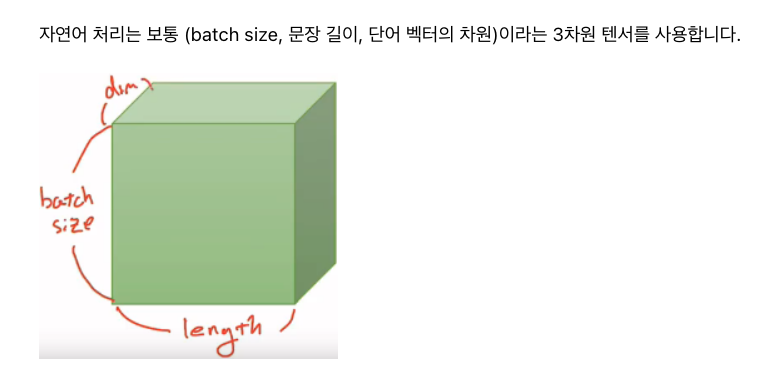